In [11]:
# import libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential # CNN
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
import os

from tqdm import tqdm

import warnings

from config import DATASET_PATH

warnings.filterwarnings('ignore')

In [12]:
# load data

# via : https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data

labels = ['NORMAL','PNEUMONIA']
img_size = 150 # 150*150px


In [13]:
def get_data(data_dir):
    data = list()
    
    for label in labels:
        path = os.path.join(data_dir, label)
        class_id = labels.index(label) # 'PNEU' = 0, 'NORM' = 1
              
        for img_name in tqdm(os.listdir(path)):
            
            try:
                # read image
                img = cv2.imread(os.path.join(path, img_name), cv2.IMREAD_GRAYSCALE)
                
                if img is None:
                    print("image can not be read")
                    continue
                
                # resize img
                resized_img =  cv2.resize(img, (img_size, img_size))    
                
                data.append([resized_img, class_id]) 
            
            except Exception as e:
                print(e)
    
    return data       
        
    

In [14]:
get_path = lambda x : os.path.join(DATASET_PATH, x)

In [15]:
train = get_data(get_path('train'))

100%|██████████| 3875/3875 [00:14<00:00, 264.01it/s]


In [16]:
test = get_data(get_path('test'))

100%|██████████| 390/390 [00:01<00:00, 301.77it/s]


In [17]:
val = get_data(get_path('val'))

100%|██████████| 8/8 [00:00<00:00, 255.98it/s]


In [18]:
print(f"train : {len(train)}\ntest : {len(test)}\nval : {len(val)}")

train : 5216
test : 624
val : 16


In [19]:
num_transfer = 1000
test = test + train[-num_transfer:]
train = train[:-num_transfer]

In [20]:
train = np.array(train, dtype = 'object')    
test = np.array(test, dtype = 'object')    
val = np.array(val, dtype = 'object')    

<Axes: ylabel='count'>

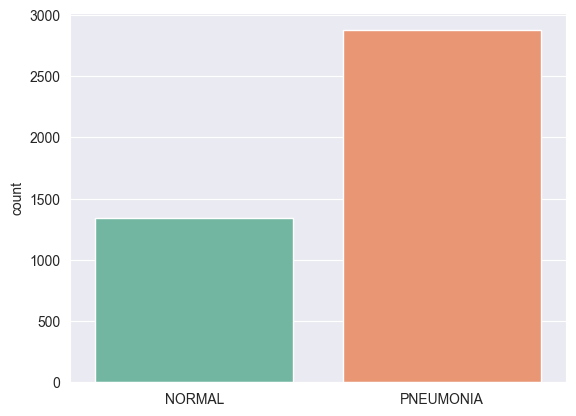

In [21]:
# data visualizition and preproccessing
l = ['NORMAL' if i[1] == 0 else 'PNEUMONIA' for i in train]

sns.countplot(x=l,palette='Set2')


In [22]:
x_train, y_train = list(), list()
x_test, y_test = list(), list()
x_val, y_val = list(), list()

for feat, label in train:
    x_train.append(feat)
    y_train.append(label)

In [23]:
for feat, label in test:
    x_test.append(feat)
    y_test.append(label)

In [24]:
for feat, label in val:
    x_val.append(feat)
    y_val.append(label)

Text(0.5, 1.0, 'NORMAL')

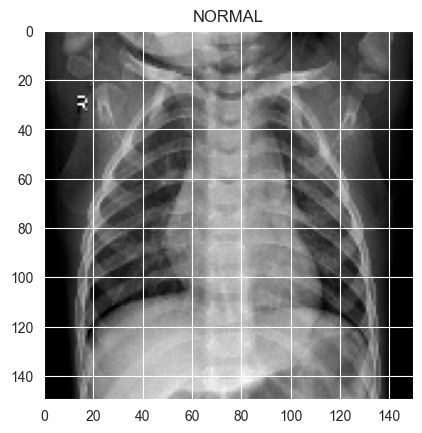

In [25]:
# visualization
plt.figure()
idx = 1
plt.imshow(train[idx][0], cmap='gray')
plt.title(labels[train[idx][1]])

Text(0.5, 1.0, 'PNEUMONIA')

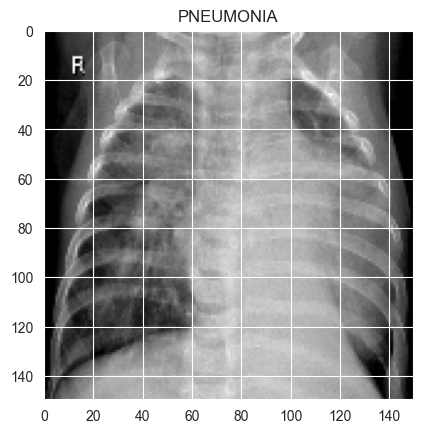

In [26]:
plt.figure()
idx = -idx
plt.imshow(train[idx][0], cmap='gray')
plt.title(labels[train[idx][1]])

In [27]:
# normalization : [0,255] -> [0,1]

x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255
x_val = np.array(x_val) / 255



In [28]:
x_train.shape
# (5216,150,150) ->(5216,150,150,1) reshape
x_train = x_train.reshape(-1, img_size, img_size, 1) # -1 : oto # 5216
x_test = x_test.reshape(-1, img_size, img_size, 1)
x_val = x_val.reshape(-1, img_size, img_size, 1)


In [29]:
x_train.shape

(4216, 150, 150, 1)

In [30]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [31]:
# data augmentation

datagen = ImageDataGenerator(
                               rotation_range=30,
                               zoom_range=0.2,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True
                               )

datagen.fit(x_train)

In [32]:
# create deep learning model and train

"""
Feature Extraction Block:
    (con2d  - Normalization - maxPooling)
    (con2d  - dropout- Normalization - maxPooling) # handle overfitting
    (con2d  - Normalization - maxPooling)
    (con2d  - dropout- Normalization - maxPooling)
    (con2d  - dropout- Normalization - maxPooling)
    
Classification:
    flatten- Dense - dropout- Dense (output)
    
Compiler :     
    optimizer(rmsprop), loss(binary_crossentropy), metrics(accuracy)
"""

# conv dict

conv_params = {
    'kernel_size': (3, 3),
    'pool_size': (2, 2),
    'padding': 'same',
    'activation': 'relu',
    'conv_strides': 1,
    'pool_strides': 2,
    'optimizer' : 'rmsprop',
    'loss' : 'binary_crossentropy',
    'metrics' : ['accuracy'],
    'epochs' : 15,
    'batch_size' : 32
}

In [37]:
# alias

ks = conv_params['kernel_size']
ps = conv_params['pool_size']
pad = conv_params['padding']
act = conv_params['activation']
conv_strides = conv_params['conv_strides']
pool_strides = conv_params['pool_strides']
optimizer = conv_params['optimizer']
loss = conv_params['loss']
metrics = conv_params['metrics']
num_epoch = conv_params['epochs']
batch_size = conv_params['batch_size']

# model construction

model = Sequential()

# 1st conv block
model.add(Conv2D(32, (7,7), strides = conv_strides, padding = pad, activation = act, input_shape = (img_size, img_size, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = ps , strides = pool_strides, padding = pad))

# 2nd conv block
model.add(Conv2D(64, (5,5), strides = conv_strides, padding = pad, activation = act)) 
model.add(Dropout(0.2)) 
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = ps , strides = pool_strides, padding = pad))

# 3rd conv block
model.add(Conv2D(64, ks, strides = conv_strides, padding = pad, activation = act))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = ps , strides = pool_strides, padding = pad))

# classification block
model.add(Flatten())
model.add(Dense(units=128, activation = act))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation = 'sigmoid')) # binary classification - output layer

model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      1600      
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        51264     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [38]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, verbose=1,min_lr=1e-6)

# train model
history = model.fit(datagen.flow(x_train,y_train,batch_size),
          epochs = num_epoch,
          verbose = 1,
          validation_data = datagen.flow(x_test,y_test),
          callbacks = [learning_rate_reduction])
            

Epoch 1/15
132/132 [==============================] - 13s 85ms/step - loss: 0.9213 - accuracy: 0.7673 - val_loss: 2.8642 - val_accuracy: 0.8559 - lr: 0.0010
Epoch 2/15
132/132 [==============================] - 11s 83ms/step - loss: 0.4347 - accuracy: 0.8373 - val_loss: 2.3012 - val_accuracy: 0.8559 - lr: 0.0010
Epoch 3/15
132/132 [==============================] - ETA: 0s - loss: 0.3904 - accuracy: 0.8534
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
132/132 [==============================] - 11s 83ms/step - loss: 0.3904 - accuracy: 0.8534 - val_loss: 15.4399 - val_accuracy: 0.8559 - lr: 0.0010
Epoch 4/15
132/132 [==============================] - 11s 83ms/step - loss: 0.2704 - accuracy: 0.8942 - val_loss: 3.2529 - val_accuracy: 0.8571 - lr: 3.0000e-04
Epoch 5/15
132/132 [==============================] - 11s 84ms/step - loss: 0.2526 - accuracy: 0.9042 - val_loss: 3.5934 - val_accuracy: 0.8559 - lr: 3.0000e-04
Epoch 6/15
132/132 [=========================

In [39]:
model.evaluate(x_test, y_test) # overfitting detected.

51/51 [==============================] - 1s 15ms/step - loss: 0.2914 - accuracy: 0.9009


[0.29143834114074707, 0.9008620977401733]